# GPyTorch Regression Tutorial

## Introduction

In this notebook, we demonstrate many of the design features of GPyTorch using the simplest example, training an RBF kernel Gaussian process on a simple function. We'll be modeling the function

\begin{align*}
  y &= \sin(2\pi x) + \epsilon \\
  \epsilon &\sim \mathcal{N}(0, 0.2)
\end{align*}

with 11 training examples, and testing on 51 test examples.

**Note:** this notebook is not necessarily intended to teach the mathematical background of Gaussian processes, but rather how to train a simple one and make predictions in GPyTorch. For a mathematical treatment, Chapter 2 of Gaussian Processes for Machine Learning provides a very thorough introduction to GP regression (this entire text is highly recommended): http://www.gaussianprocess.org/gpml/chapters/RW2.pdf

In [1]:
import math
import torch
import gpytorch
import spectralgp
from matplotlib import pyplot as plt

torch.set_default_tensor_type(torch.cuda.FloatTensor)
%set_env CUDA_VISIBLE_DEVICES=1

%matplotlib inline
%load_ext autoreload
%autoreload 2

env: CUDA_VISIBLE_DEVICES=1


In [2]:
from pyro.contrib.examples.bart import load_bart_od
dataset = load_bart_od()
X = torch.arange(0, 70128).repeat(47, 1).unsqueeze(-1).float()
y = dataset['counts'].sum(-1).transpose(-2, -1)
stations = ['MONT', 'POWL', 'EMBR'] # , 'CIVC', '12TH', '19TH', '16TH', '24TH', 'DBRK']
station_idxs = [dataset['stations'].index(st) for st in stations]


X = X[station_idxs]
y = y[station_idxs]

In [3]:
train_start = 365*24*7
train_length = 24*60
train_end = train_start + train_length
test_length = 10*24

train_x = X[:, train_start:train_end, :]
train_y = y[:, train_start:train_end]
test_x = X[:, train_end:train_end + test_length, :]
test_y = y[:, train_end:train_end + test_length]

train_x, train_y, test_x, test_y = train_x.cuda(), train_y.cuda(), test_x.cuda(), test_y.cuda()

In [4]:

train_x_min = train_x.min()
train_x_max = train_x.max()

train_x = train_x - train_x_min
test_x = test_x - train_x_min
# test_x = (test_x - train_x_min) / (train_x_max - train_x_min)
# train_x = (train_x - train_x_min) / (train_x_max - train_x_min)

train_y_mean = train_y.mean(dim=-1, keepdim=True)
train_y_std = train_y.std(dim=-1, keepdim=True)

train_y = (train_y - train_y_mean) / train_y_std

test_y = (test_y - train_y_mean) / train_y_std

torch.Size([3, 1440, 1]) torch.Size([3, 1440]) torch.Size([3, 240, 1]) torch.Size([3, 240])


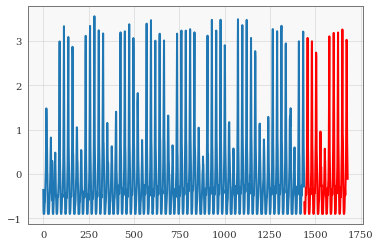

In [5]:
station = 1

plt.plot(train_x[station].cpu(), train_y[station].cpu())
plt.plot(test_x[station].cpu(), test_y[station].cpu(), 'r')

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

In [6]:
from botorch.fit import fit_gpytorch_model
from gpytorch.kernels import ScaleKernel
from gpytorch.kernels.spectral_autoregressive_flow_kernel import RFNSSpectralNFKernel, RFNSSpectralDeltaKernel
from gpytorch.mlls import ExactMarginalLogLikelihood

In [7]:
data_lh_list = []
data_mod_list = []
latent_mod = None
latent_lh = None

for j in range(len(stations)):
    data_lh_list.append(gpytorch.likelihoods.GaussianLikelihood(noise_prior=gpytorch.priors.SmoothedBoxPrior(1e-8, 1e-3)))
    model_j = spectralgp.models.SpectralModel(
        train_x[j, :],
        train_y[j, :],
        likelihood=data_lh_list[j],
        normalize=False,
        num_locs=200,
        spacing='even',
        omega_max=1.0,
        latent_mod=latent_mod if latent_mod is not None else latent_mod,
        latent_lh=latent_lh if latent_lh is not None else latent_lh,
        
    )
#     model_j = model_j.cuda()
#     model_j.set_train_data(train_x[j, :], train_y[j, :])
    data_mod_list.append(model_j)
    latent_lh, latent_mod = data_mod_list[j].covar_module.latent_lh, data_mod_list[j].covar_module.latent_mod

(1e-10, 1.0)


/opt/conda/conda-bld/pytorch_1579853260681/work/torch/csrc/autograd/generated/python_variable_methods.cpp:1550: UserWarning: This overload of addcmul_ is deprecated:
addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
addcmul_(Tensor tensor1, Tensor tensor2, Number value)
/opt/conda/conda-bld/pytorch_1579853260681/work/torch/csrc/autograd/generated/python_variable_methods.cpp:1334: UserWarning: This overload of add_ is deprecated:
add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
add_(Tensor other, Number alpha)
/opt/conda/conda-bld/pytorch_1579853260681/work/torch/csrc/autograd/generated/python_variable_methods.cpp:1480: UserWarning: This overload of addcdiv_ is deprecated:
addcdiv_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
addcdiv_(Tensor tensor1, Tensor tensor2, Number value)


(1e-10, 1.0)
(1e-10, 1.0)


In [8]:
alt_sampler = spectralgp.samplers.AlternatingSampler(data_mod_list, data_lh_list,
                    spectralgp.sampling_factories.ss_multmodel_factory,
                    [spectralgp.sampling_factories.ess_factory] * len(stations),
                    numInnerSamples=10, numOuterSamples=100,
                    totalSamples=1,
                    num_dims=1, num_tasks=len(stations)
                    )
alt_sampler.run()
omega = latent_mod.train_inputs[0]

Task: 0 ; Iteration 0
Task: 1 ; Iteration 0
Task: 2 ; Iteration 0
Seconds for Iteration 0 : 52.32637023925781


In [9]:
n_samples = min(alt_sampler.gsampled[0].shape[2], 10)

test_x_f = torch.cat([train_x, test_x], dim=-2)

pred_data = torch.zeros(train_y.shape[0], test_x_f.size(-2), n_samples)
lower_pred = torch.zeros(train_y.shape[0], test_x_f.size(-2), n_samples)
upper_pred = torch.zeros(train_y.shape[0], test_x_f.size(-2), n_samples)

for stn in range(train_y.shape[0]):
    data_mod = data_mod_list[stn]
    out_samples = alt_sampler.gsampled[0][stn, :, -n_samples:].detach()    
    
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        for ii in range(n_samples):
            data_mod.covar_module.set_latent_params(out_samples[:, ii])
            data_mod.set_train_data(train_x[stn, :], train_y[stn, :])
            data_mod.eval()
            out = data_mod(test_x_f[stn])
            lower_pred[stn, :, ii], upper_pred[stn, :, ii] = out.confidence_region()
            pred_data[stn, :, ii] = out.mean

RuntimeError: CUDA out of memory. Tried to allocate 1.79 GiB (GPU 0; 10.73 GiB total capacity; 5.42 GiB already allocated; 1.40 GiB free; 6.96 GiB reserved in total by PyTorch)

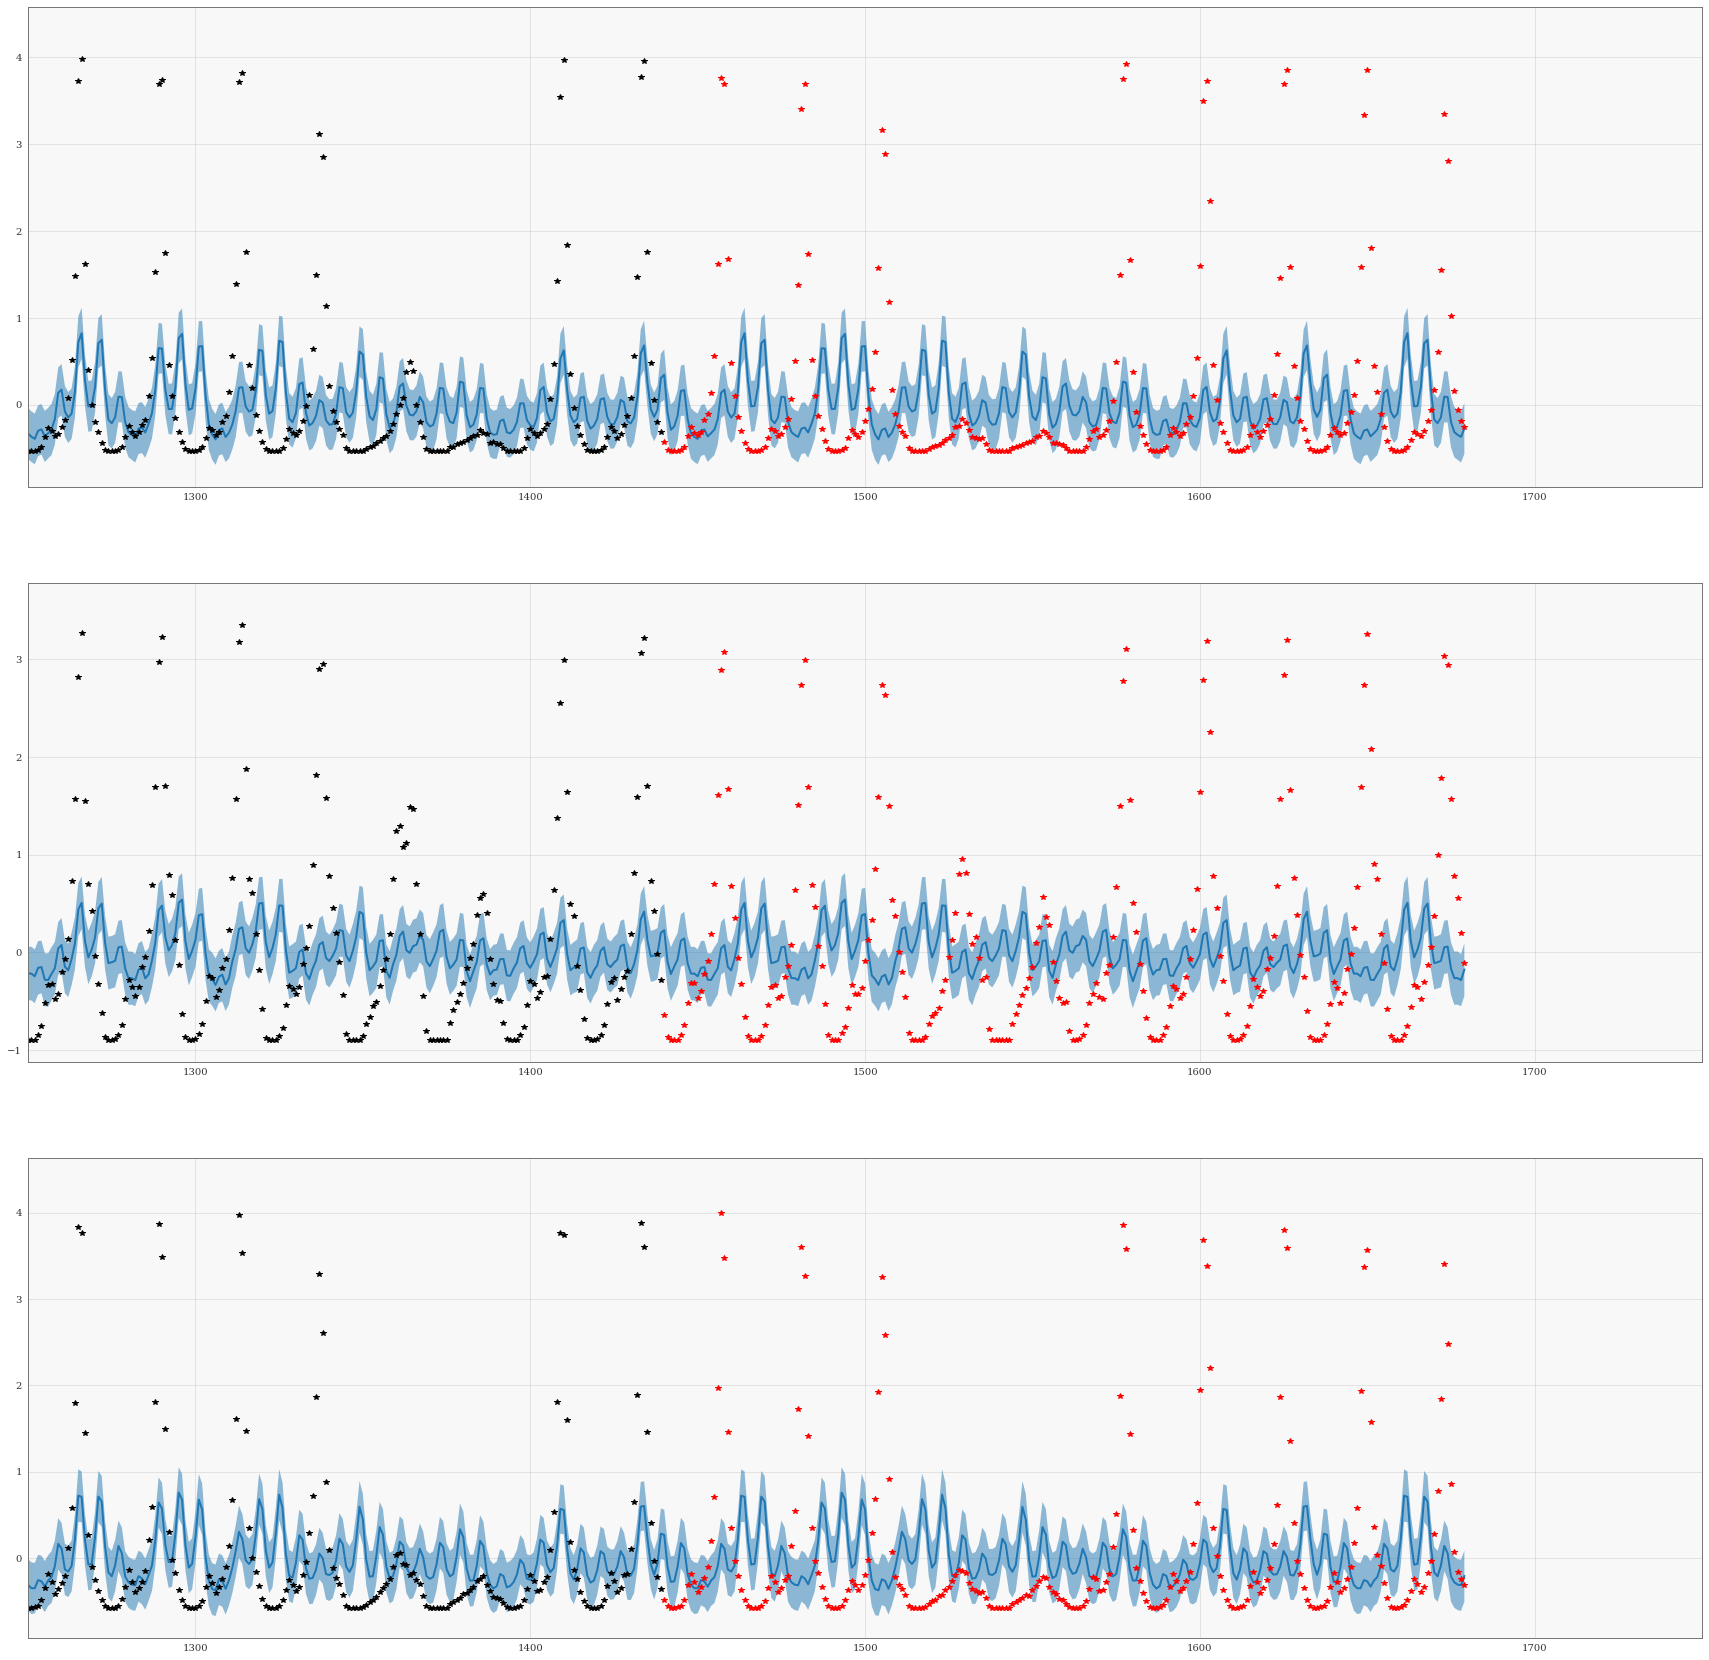

In [15]:
# pred_data = pred_data.detach().cpu().numpy()

plt.figure(figsize=(30, 30))
for _task in range(train_y.shape[0]):
    ax = plt.subplot(3, 1, _task + 1)
    ax.plot(test_x_f[_task].detach().cpu().numpy(), pred_data[_task, :, 0].detach().cpu().numpy())
    ax.plot(train_x[_task].detach().cpu().numpy(), train_y[_task].detach().cpu().numpy(), 'k*')
    ax.plot(test_x[_task].detach().cpu().numpy(), test_y[_task].detach().cpu().numpy(), 'r*')
    plt.fill_between(test_x_f[_task].detach().cpu().numpy().squeeze(), lower_pred[_task, :, 0].detach().cpu().numpy(), upper_pred[_task, :, 0].detach().cpu().numpy(), alpha=0.5)
    plt.xlim([1250, 1750])

In [36]:
pred_data.shape

torch.Size([1680, 10])

## Plot the model fit


In the next cell, we plot the mean and confidence region of the Gaussian process model. The `confidence_region` method is a helper method that returns 2 standard deviations above and below the mean.

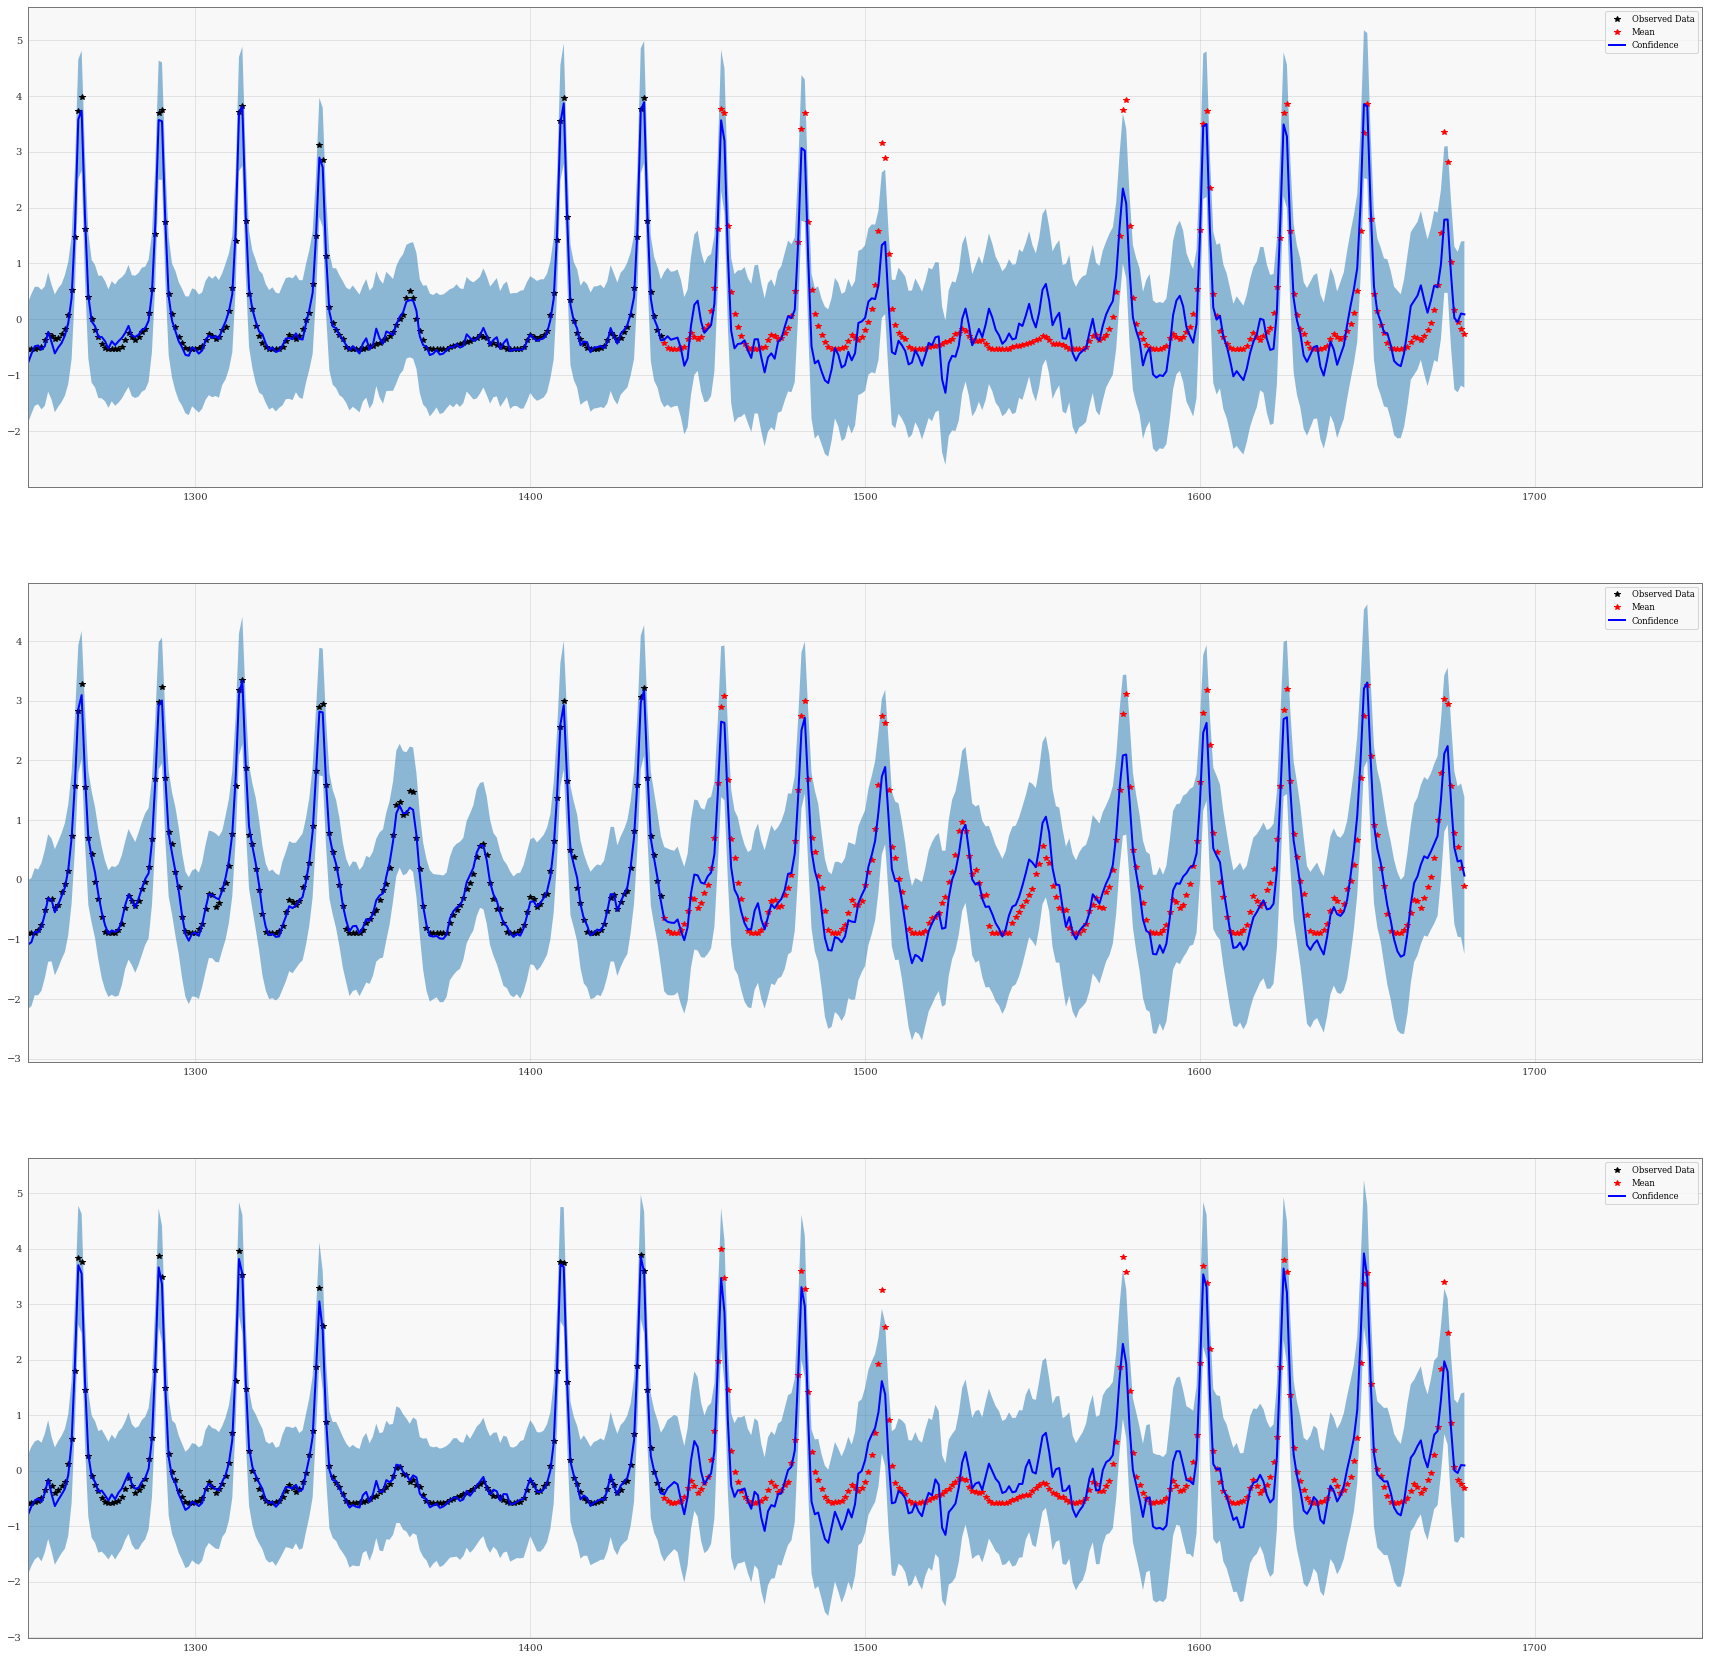

In [17]:
_task = 3

plt.figure(figsize=(30, 30))
for _task in range(3):
    ax = plt.subplot(3, 1, _task + 1)

    with torch.no_grad():
        # Initialize plot
#         f, ax = plt.subplots(1, 1, figsize=(16, 12))

        # Get upper and lower confidence bounds
        lower = observed_pred.mean - varz.sqrt() * 1.98
        upper = observed_pred.mean + varz.sqrt() * 1.98
        lower = lower[_task] #  + weight * test_x_f.squeeze()
        upper = upper[_task] # + weight * test_x_f.squeeze()

        # Plot training data as black stars
        ax.plot(train_x[_task].detach().cpu().numpy(), train_y[_task].detach().cpu().numpy(), 'k*')
        ax.plot(test_x[_task].detach().cpu().numpy(), test_y[_task].detach().cpu().numpy(), 'r*')
        # Plot predictive means as blue line
        ax.plot(test_x_f[_task].detach().cpu().numpy(), (observed_pred.mean[_task]).detach().cpu().numpy(), 'b')
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x_f[_task].detach().cpu().squeeze().numpy(), lower.detach().cpu().numpy(), upper.detach().cpu().numpy(), alpha=0.5)
    #     ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])
        plt.xlim([1250, 1750])

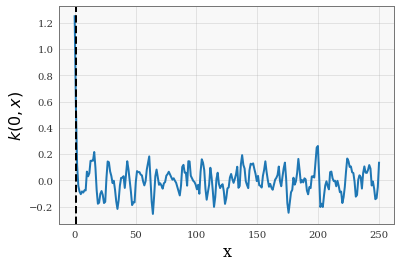

In [65]:
with torch.no_grad():
    xr = torch.linspace(0, 250, 250).cuda()
    plt.plot(xr.cpu().numpy(), model.covar_module(torch.tensor([0]).cuda(), xr).evaluate().detach().cpu().squeeze().numpy())
    plt.axvline(1.0, linestyle='--', color='k')
    plt.ylabel('$k(0, x)$', fontsize=16)
    plt.xlabel('x', fontsize=16)

(array([1.000e+00, 1.244e+03, 4.520e+02, 6.900e+01, 8.100e+01, 1.220e+02,
        2.100e+01, 3.900e+01, 6.000e+00, 3.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00]),
 array([7.69715573e-06, 5.64711659e-02, 1.12934635e-01, 1.69398104e-01,
        2.25861572e-01, 2.82325041e-01, 3.38788510e-01, 3.95251979e-01,
        4.51715448e-01, 5.08178916e-01, 5.64642385e-01, 6.21105854e-01,
        6.77569323e-01, 7.34032791e-01, 7.90496260e-01, 8.46959729e-01,
        9.03423198e-01, 9.59886667e-01, 1.01635014e+00, 1.07281360e+00,
        1.12927707e+00]),
 <a list of 20 Patch objects>)

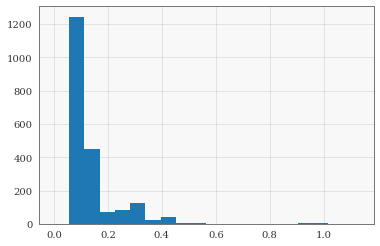

In [28]:
plt.hist(model.covar_module.base_kernel.Z.detach().cpu().numpy(), bins=20)

In [15]:
x0 = torch.tensor([0.]).cuda()
x1 = torch.linspace(0, 10, 500).unsqueeze(-1).cuda()
plt.plot(model.covar_module.forward(x0, x1).squeeze().cpu().detach().numpy())

TypeError: squeeze() missing 1 required positional argument: 'dim'

In [17]:
model.covar_module.lengthscale

tensor([[2.6730]], device='cuda:0', grad_fn=<SoftplusBackward>)

(array([950.,  22.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   1.,  22.]),
 array([-1.44398087, -1.37944732, -1.31491378, -1.25038023, -1.18584668,
        -1.12131314, -1.05677959, -0.99224604, -0.9277125 , -0.86317895,
        -0.7986454 , -0.73411186, -0.66957831, -0.60504476, -0.54051122,
        -0.47597767, -0.41144412, -0.34691058, -0.28237703, -0.21784348,
        -0.15330994, -0.08877639, -0.02424284,  0.0402907 ,  0.10482425,
         0.1693578 ,  0.23389134,  0.29842489,  0.36295844,  0.42749198,
         0.49202553]),
 <a list of 30 Patch objects>)

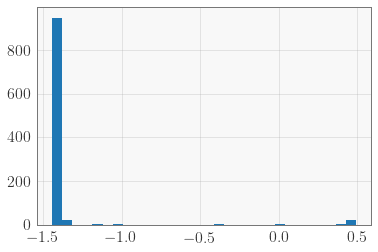

In [65]:
plt.hist(samples[:, 0].cpu().detach().numpy(), bins=30)

(array([340., 127.,   1.,   1.,   0.,   2.,   1.,   1.,   0.,  18.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,  32., 442.,
         29.,   0.,   0.,   0.,   0.,   1.,   0.,   4.]),
 array([-0.521559  , -0.4539332 , -0.38630741, -0.31868162, -0.25105583,
        -0.18343004, -0.11580425, -0.04817846,  0.01944733,  0.08707312,
         0.15469891,  0.2223247 ,  0.28995049,  0.35757628,  0.42520208,
         0.49282787,  0.56045366,  0.62807945,  0.69570524,  0.76333103,
         0.83095682,  0.89858261,  0.9662084 ,  1.03383419,  1.10145998,
         1.16908577,  1.23671157,  1.30433736,  1.37196315,  1.43958894,
         1.50721473]),
 <a list of 30 Patch objects>)

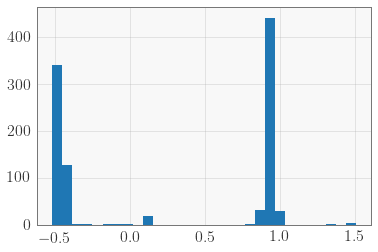

In [66]:
plt.hist(samples[:, 1].cpu().detach().numpy(), bins=30)